In [1]:
import shap
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

c:\Users\theow\Documents\Project\Explainable-Loan-Default\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = joblib.load(r"C:\Users\theow\Documents\Project\Explainable-Loan-Default\models\best_xgb_model.pkl")  
X_train = pd.read_csv(r"C:\Users\theow\Documents\Project\Explainable-Loan-Default\data\processed/X_train.csv")
y_train = pd.read_csv(r"C:\Users\theow\Documents\Project\Explainable-Loan-Default\data\processed\y_train.csv").values.ravel()


In [4]:
# Ensure X_train is a DataFrame (not numpy)
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train)

# Select only categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# One-hot encode categorical features if any
if categorical_cols:
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoded = encoder.fit_transform(X_train[categorical_cols])
    encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)

    # Drop original categorical and add encoded
    X_train = X_train.drop(columns=categorical_cols)
    X_train = pd.concat([X_train, encoded_df], axis=1)

In [6]:
print(X_train.dtypes)


person_age                     float64
person_income                  float64
person_emp_length              float64
loan_amnt                      float64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_default_on_file        int64
cb_person_cred_hist_length     float64
loan_grade_encoded             float64
loan_intent_EDUCATION             bool
loan_intent_HOMEIMPROVEMENT       bool
loan_intent_MEDICAL               bool
loan_intent_PERSONAL              bool
loan_intent_VENTURE               bool
person_home_ownership_OTHER       bool
person_home_ownership_OWN         bool
person_home_ownership_RENT        bool
dtype: object


In [7]:
# Convert boolean columns to integers
bool_columns = X_train.select_dtypes(include=['bool']).columns
X_train[bool_columns] = X_train[bool_columns].astype(int)

# Ensure all columns are numeric
for column in X_train.columns:
    if X_train[column].dtype == 'O':
        X_train[column] = pd.to_numeric(X_train[column], errors='coerce')

In [8]:
# Check data types
print(X_train.dtypes)

person_age                     float64
person_income                  float64
person_emp_length              float64
loan_amnt                      float64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_default_on_file        int64
cb_person_cred_hist_length     float64
loan_grade_encoded             float64
loan_intent_EDUCATION            int64
loan_intent_HOMEIMPROVEMENT      int64
loan_intent_MEDICAL              int64
loan_intent_PERSONAL             int64
loan_intent_VENTURE              int64
person_home_ownership_OTHER      int64
person_home_ownership_OWN        int64
person_home_ownership_RENT       int64
dtype: object


In [16]:
# Check missing
print(X_train.isnull().sum())

person_age                         0
person_income                      0
person_emp_length                  0
loan_amnt                          0
loan_int_rate                      0
loan_percent_income                0
cb_person_default_on_file          0
cb_person_cred_hist_length         0
loan_grade_encoded                 0
loan_intent_EDUCATION              0
loan_intent_HOMEIMPROVEMENT        0
loan_intent_MEDICAL                0
loan_intent_PERSONAL               0
loan_intent_VENTURE                0
person_home_ownership_OTHER        0
person_home_ownership_OWN          0
person_home_ownership_RENT         0
income_bracket                 14528
dtype: int64


In [9]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)


 99%|===================| 22723/22910 [01:29<00:00]        

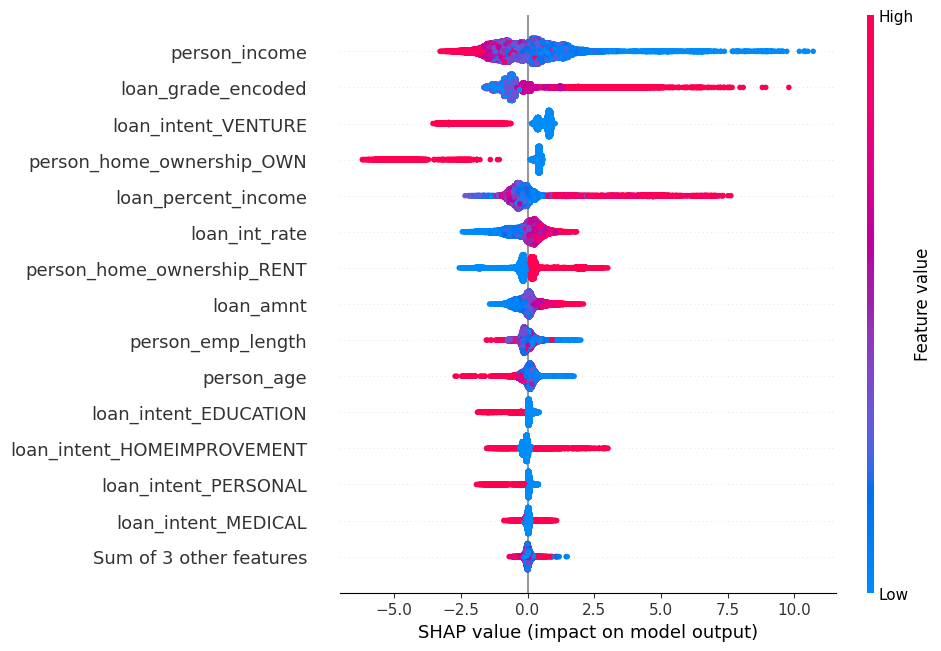

Text(0.5, 1.0, 'SHAP Summary Plot (Global Importance)')

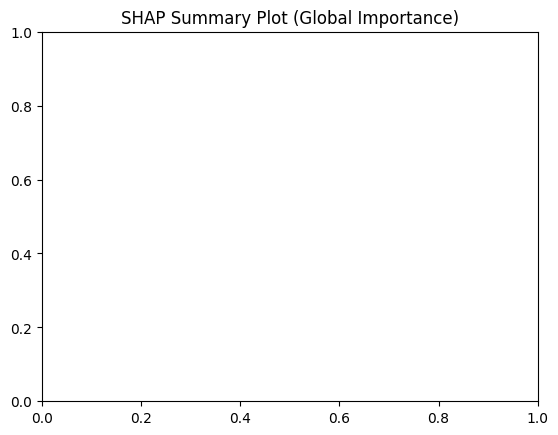

In [14]:
shap.plots.beeswarm(shap_values, max_display=15)
plt.title("SHAP Summary Plot (Global Importance)")


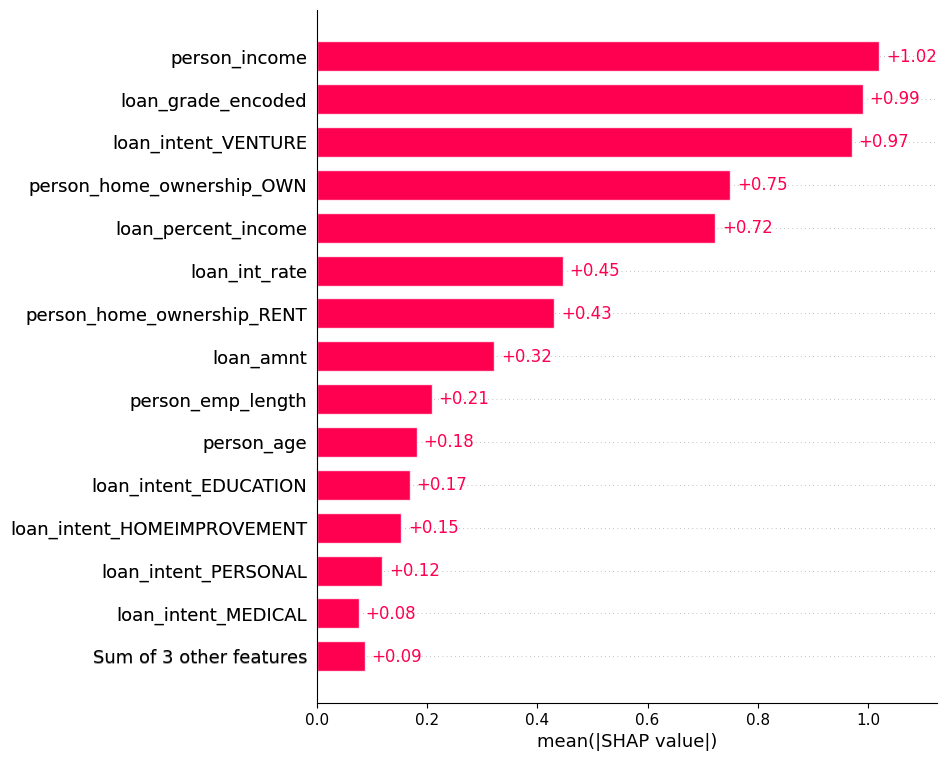

Text(0.5, 1.0, 'Feature Importance - SHAP Bar Plot')

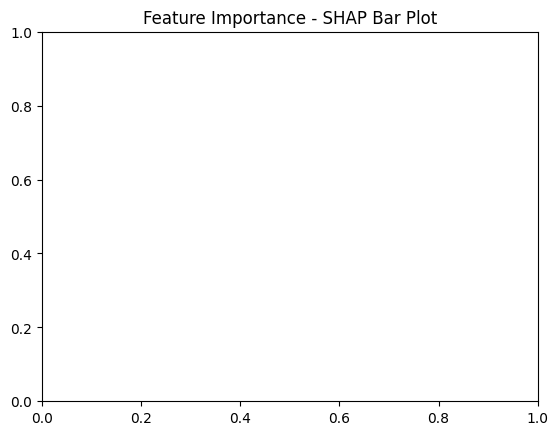

In [10]:
# SHAP bar plot
shap.plots.bar(shap_values, max_display=15)
plt.title("Feature Importance - SHAP Bar Plot")


Cohort Analysis Using SHAP Values

In [13]:
# Ensure all columns are numeric
for column in X_train.columns:
    if X_train[column].dtype == 'O':
        X_train[column] = pd.to_numeric(X_train[column], errors='coerce')

In [17]:
bins = [0, 20000, 50000, 100000, 200000, 1000000, np.inf]
labels = ['Low', 'Lower-Mid', 'Mid', 'Upper-Mid', 'High', 'Ultra High']


 97%|=================== | 8146/8382 [00:34<00:00]       

Generating SHAP summary for Low income bracket...


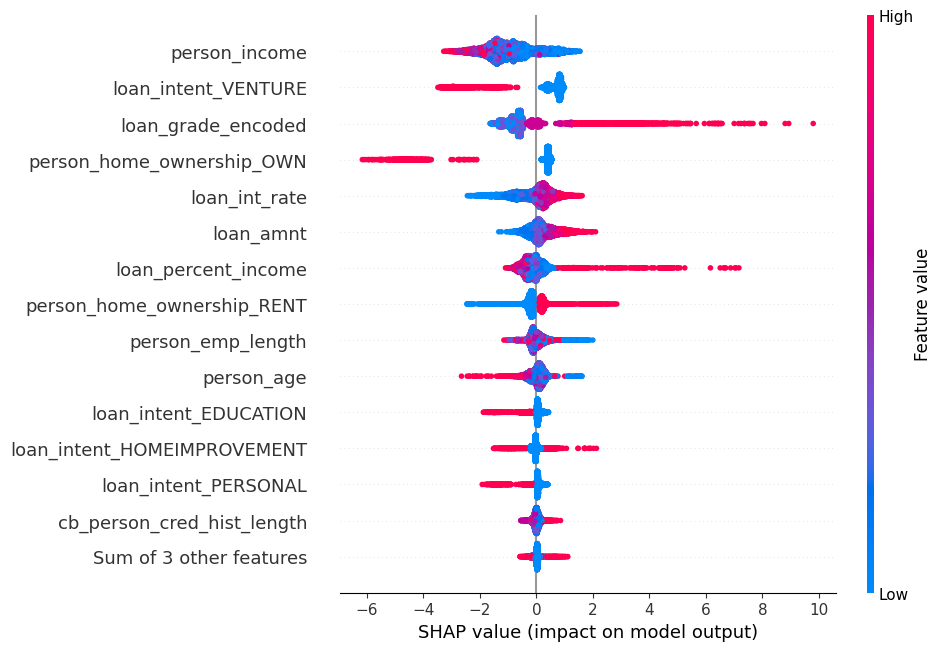

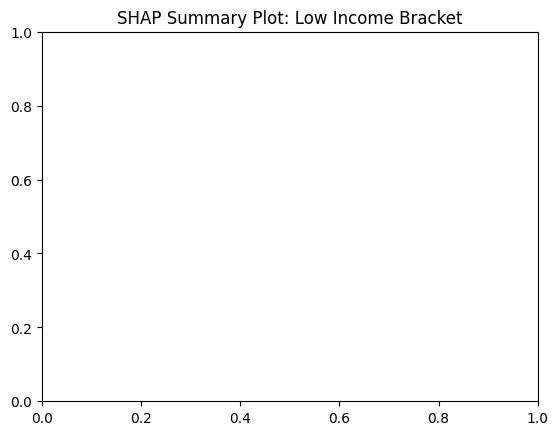

In [20]:
# Create a cohort column for example (you can adjust based on relevant features)
X_train['income_bracket'] = pd.cut(
    X_train['person_income'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Define the cohort column
cohort = 'income_bracket'

# Drop rows with NaNs in the cohort column (just in case)
cohort_values = X_train[cohort].dropna().unique()

# Loop through each cohort and plot SHAP summary
for bracket in cohort_values:
    # Select the subset of data for this cohort
    cohort_data = X_train[X_train[cohort] == bracket]

     # Drop the cohort column from the data
    cohort_data = cohort_data.drop(columns=[cohort])
    
    # If cohort_data is too small, skip to avoid errors
    if cohort_data.shape[0] < 5:
        print(f"Skipping {bracket} due to small sample size.")
        continue

    # Compute SHAP values
    cohort_shap_values = explainer(cohort_data)
    
    # Plot SHAP summary for the cohort
    print(f"Generating SHAP summary for {bracket} income bracket...")
    shap.plots.beeswarm(cohort_shap_values, max_display=15)
    plt.title(f"SHAP Summary Plot: {bracket} Income Bracket")
    plt.show()


SHAP Dependence Plots

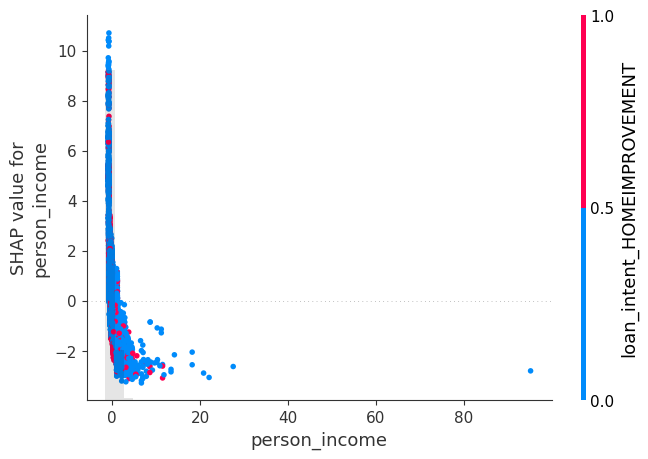

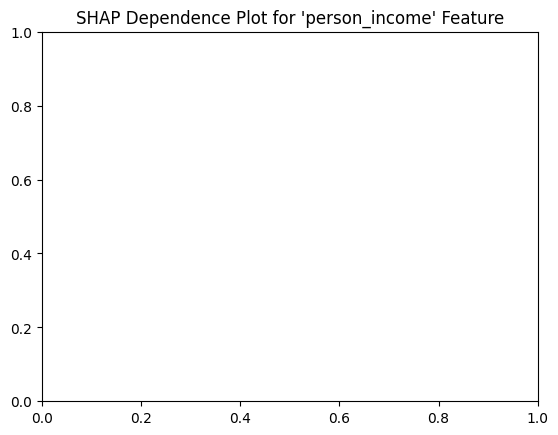

In [22]:
# SHAP dependence plot for 'person_income'
shap.plots.scatter(shap_values[:, "person_income"], color=shap_values)
plt.title("SHAP Dependence Plot for 'person_income' Feature")
plt.show()

Local Explainability for Individual Prediction (Waterfall Plot)

SHAP values shape: (1, 18)
SHAP values: .values =
array([[ 0.11503077, -0.28278185,  0.18447252, -0.11378161, -1.04930966,
        -0.04261295, -0.01630815, -0.10968686, -0.74804215, -0.01580048,
        -0.26256583, -0.01100788,  0.01775149, -2.82410901, -0.12440072,
        -3.47480348, -0.09715819,  0.        ]])

.base_values =
array([-3.06836277])

.data =
array([[np.float64(-0.9075935673909892), np.float64(-0.2990821041542882),
        np.float64(0.2915662109618342), np.float64(0.3702472402705128),
        np.float64(-1.5513711194071398), np.float64(0.7567573340240529),
        np.int64(0), np.float64(-0.6917906346930213), np.float64(0.0),
        np.int64(0), np.int64(0), np.int64(0), np.int64(0), np.int64(1),
        np.int64(0), np.int64(1), np.int64(0), nan]], dtype=object)


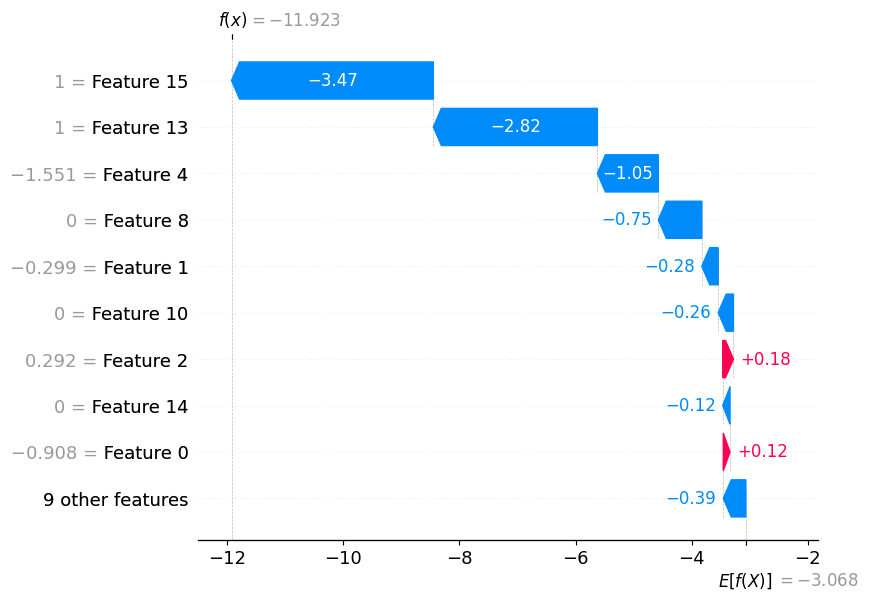

In [24]:
# Pick a sample to explain (for example, the first sample in the training set)
sample = X_train.iloc[0]

# Ensure the sample is correctly formatted
sample = sample.values.reshape(1, -1)

# Get SHAP values for the sample
shap_values_single = explainer(sample)

# Check the SHAP values
print("SHAP values shape:", shap_values_single.shape)
print("SHAP values:", shap_values_single)

# Plot waterfall
shap.plots.waterfall(shap_values_single[0])


In [27]:
# Drop the 'income_bracket' column from X_train for SHAP analysis
X_train_numeric = X_train.drop(columns=['income_bracket'])

# Create the SHAP explainer
explainer = shap.TreeExplainer(model)

# Get SHAP values for the numeric data
shap_values = explainer.shap_values(X_train_numeric)

# Save SHAP values as a DataFrame
shap_df = pd.DataFrame(shap_values, columns=X_train_numeric.columns)

# Add the 'income_bracket' column back to the SHAP DataFrame for reporting
shap_df['income_bracket'] = X_train['income_bracket']

# Save to CSV
shap_df.to_csv(r"C:\Users\theow\Documents\Project\Explainable-Loan-Default\results\shap_values.csv", index=False)